In [1]:

####################################################################################################
####################################################################################################

import datetime
import sys
import glob
import json
import os.path
import pprint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

from IPython.display import display
#from IPython.display import Image
from PIL import Image

#
import keras
from keras import backend as K
from keras import layers
from keras import regularizers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras.models import Sequential
from keras.utils import plot_model

sys.path.append(os.path.abspath("../../"))
sys.path.append(os.path.abspath("../../pax_utils"))
from s1s2_utils import *

from model_xy_s2waveforms_dnn import *



Using TensorFlow backend.


In [2]:

####################################################################################################
####################################################################################################
    
nEventsFile  = 25000
nEventsTrain = 20000
resample_factor = 229
resample_factor = 10

s2_window_max   = 2290
n_timesteps     = int(s2_window_max / resample_factor)

file_out_input = 'train/array_train_input_events%06d_resample%04d' % (nEventsFile, resample_factor)
file_out_truth = 'train/array_train_truth_events%06d_resample%04d' % (nEventsFile, resample_factor)

train_data  = np.load(file_out_input + '.npy')
train_truth = np.load(file_out_truth + '.npy')

train_data  = train_data [0:nEventsTrain, :]
train_truth = train_truth[0:nEventsTrain, :]

print(train_data.shape)
print(train_truth.shape)



(20000, 29083)
(20000, 2)


In [3]:

####################################################################################################
####################################################################################################

n_events     = nEventsTrain
n_channels   = 127
n_outputs    = 2

#n_timesteps  = 1

go_backwards = False
unroll       = False


####################################################################################################
# Training Data
####################################################################################################

print()
print("Channels:         " + str(n_channels))
print("Timesteps:        " + str(n_timesteps))
print("Outputs:          " + str(n_outputs) )
print("Input data shape: " + str(train_data.shape ))
print("Truth data shape: " + str(train_truth.shape))
print()




Channels:         127
Timesteps:        229
Outputs:          2
Input data shape: (20000, 29083)
Truth data shape: (20000, 2)




Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29083)             845849972 
_________________________________________________________________
dense_2 (Dense)              (None, 29083)             845849972 
_________________________________________________________________
dropout_1 (Dropout)          (None, 29083)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 14541)             422910444 
_________________________________________________________________
dropout_2 (Dropout)          (None, 14541)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 7270)              105720340 
_________________________________________________________________
dropout_3 (Dropout)          (None, 7270)              0    

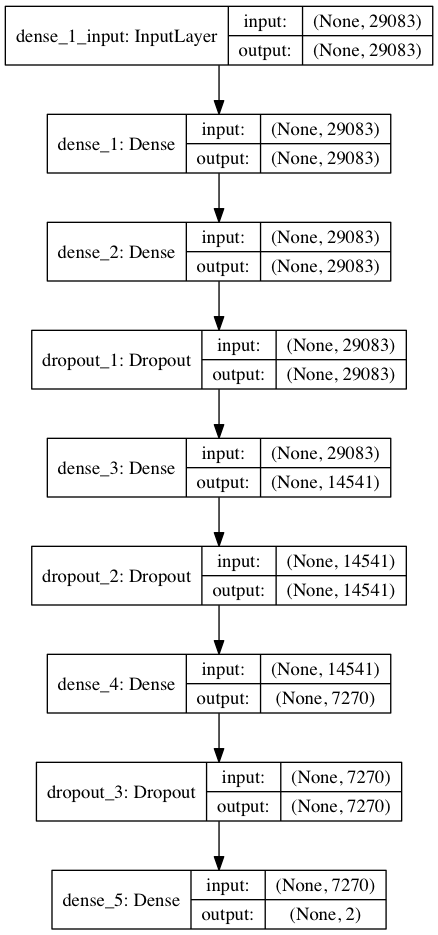

In [4]:

####################################################################################################
####################################################################################################

#model, name = dnnModel_s2integrals('elu', 0.00005)

model, name = dnnModel(n_channels, n_timesteps, n_outputs, 'elu', 0.00005)


######################################################################################
######################################################################################

name_png = 'models/' + name + ".png"
name_h5  = 'models/' + name + ".h5"

plot_model(model, to_file=name_png, show_layer_names=True, show_shapes=True)
  
print()
print("Model Summary:")
model.summary()
print()
display(Image.open(name_png))
print()



In [ ]:

######################################################################################
######################################################################################

# to do: reset model 

history = model.fit(
    train_data,
    train_truth,
    batch_size=64,
    epochs=1,
    verbose=True
)

print("Training Complete.")


Epoch 1/1


In [45]:

######################################################################################
######################################################################################

pp = pprint.PrettyPrinter(depth=2)

config = model.get_config()

str_layers = "layers"

for key, value in enumerate(config):
    
    node_type = value.get('class_name')
    
    if (node_type == 'Dropout'): continue
        
    node_num  = value.get('config').get('units')
    
    str_layers += '-' + str(node_num)
    
    continue
    


layers-1270-1270-635-317-2


In [ ]:
from keras import layers

config  = model.get_config()
history = history.history.keys()

print(config)
print()
print(history)


In [55]:


######################################################################################
# Save Model
######################################################################################

# loss

folder   = "models/"    
name_h5  = folder + name + '_' + str_layers + ".h5"
name_cfg = folder + name + '_' + str_layers + ".json"

name_h5  = name_h5.replace('in1270_out2_', '')
name_cfg = name_cfg.replace('in1270_out2_', '')

print(name_h5)
print(name_cfg)

model.save(name_h5, overwrite=True)


######################################################################################
######################################################################################

config_test = {}

with open(name_cfg, 'w') as fp: json.dump(config, fp)
with open(name_cfg, 'r') as fp: config_test = json.load(fp)



models/model_xy_s2waveforms_dnn_elu_layers-1270-1270-635-317-2.h5
models/model_xy_s2waveforms_dnn_elu_layers-1270-1270-635-317-2.json


In [54]:

######################################################################################
######################################################################################

print()
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(config_test)
print()



[{'class_name': 'Dense',
  'config': {'activation': 'linear',
             'activity_regularizer': None,
             'batch_input_shape': [None, 1270],
             'bias_constraint': None,
             'bias_initializer': {'class_name': 'Zeros', 'config': {}},
             'bias_regularizer': None,
             'dtype': 'float32',
             'kernel_constraint': None,
             'kernel_initializer': {'class_name': 'VarianceScaling',
                                    'config': {...}},
             'kernel_regularizer': None,
             'name': 'dense_1',
             'trainable': True,
             'units': 1270,
             'use_bias': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'elu',
             'activity_regularizer': None,
             'bias_constraint': None,
             'bias_initializer': {'class_name': 'Zeros', 'config': {}},
             'bias_regularizer': None,
             'kernel_constraint': None,
             'kernel_initializer': {'class_n